## RNN(Recurrent Neural Network)で正弦波のモデリングを行う

このノートブックでは、系列データのモデリング事例として正弦波のモデリングをRNNで行うサンプルを示す。

In [77]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# ハイパーパラメータの設定
input_size = 1  # 入力は正弦波の1点
hidden_size = 20 # 隠れ層のサイズ
output_size = 1 # 出力は次の正弦波の1点
num_layers = 1 # RNNの層数
sequence_length = 30 # 系列の長さ
batch_size = 8 # バッチサイズ
num_epochs = 500 # エポック数
learning_rate = 0.01 # 学習率
noise_level = 0.1 # 正弦波に加えるノイズのレベル

**説明:**

*   必要なライブラリをインポートし、ハイパーパラメータを設定します。
*   `input_size`: 各タイムステップにおける入力データの次元数（正弦波の1点なので1）。
*   `hidden_size`: RNNの隠れ層のサイズ。
*   `output_size`: 出力の次元数（次のタイムステップの正弦波の値なので1）。
*   `num_layers`: RNNの層数。
*   `sequence_length`: 時系列データの長さ。
*   `batch_size`: ミニバッチのサイズ。
*   `num_epochs`: 学習のエポック数。
*   `learning_rate`: 学習率。
*   `noise_level`: 正弦波に加えるノイズのレベル（標準偏差）。この値を調整することで、モデルのロバスト性を評価できます。

In [78]:
# RNNモデルの定義
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) # RNN層
        self.fc = nn.Linear(hidden_size, output_size) # 全結合層

    def forward(self, x):
        # 初期隠れ状態の作成
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # RNN層への入力
        out, _ = self.rnn(x, h0)

        # 最後のタイムステップの隠れ状態を使用
        out = self.fc(out)

        return out

**説明:**

*   `SimpleRNN`クラスは、RNNモデルを定義します。
*   `__init__`メソッドで、RNN層と全結合層を定義します。
    *   `nn.RNN`: RNN層を定義します。`input_size`, `hidden_size`, `num_layers`は、上で定義したハイパーパラメータを使用します。`batch_first=True`は、入力データの形状を`(batch_size, sequence_length, input_size)`とすることを指定します。
    *   `nn.Linear`: 全結合層を定義します。RNN層の出力（最後のタイムステップの隠れ状態）を、`output_size`の次元に変換します。
*   `forward`メソッドで、順伝播の処理を定義します。
    *   `h0`: 初期隠れ状態をゼロで初期化します。形状は`(num_layers, batch_size, hidden_size)`である必要があります。`.to(x.device)`で、入力データと同じデバイス（CPUまたはGPU）に配置します。
    *   `out, _ = self.rnn(x, h0)`: RNN層に入力データを渡します。
    *   `out = self.fc(out)`: 隠れ状態を全結合層に入力し、出力を得ます。

In [79]:
# デバイスの設定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# モデルのインスタンス化
model = SimpleRNN(input_size, hidden_size, output_size, num_layers).to(device)

# 損失関数と最適化アルゴリズムの定義
criterion = nn.MSELoss() # 平均二乗誤差
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Adam optimizer

**説明:**

*   `device`: CUDAが利用可能な場合はGPUを使用し、そうでない場合はCPUを使用するようにデバイスを設定します。
*   `model`: `SimpleRNN`クラスのインスタンスを作成し、指定したデバイスに配置します。
*   `criterion`: 損失関数として、平均二乗誤差を使用します。正弦波の予測は回帰問題なので、適切な損失関数です。
*   `optimizer`: 最適化アルゴリズムとして、Adamを使用します。

In [80]:
# データの生成 (正弦波にノイズを追加)
def generate_sine_wave(sequence_length, batch_size, noise_level=0.1):
    time = np.linspace(0, 10, sequence_length + 1, endpoint=True)
    sine_wave = np.sin(time)

    # ノイズの生成
    noise = np.random.normal(0, noise_level, size=sine_wave.shape)
    noisy_sine_wave = sine_wave + noise

    x = []
    y = []
    for i in range(sequence_length):
        x.append(noisy_sine_wave[i:i+1])
        y.append(noisy_sine_wave[i+1:i+2])

    x = np.array(x).reshape(sequence_length, 1)
    y = np.array(y).reshape(sequence_length, 1)

    x = np.tile(x, (batch_size, 1, 1))
    y = np.tile(y, (batch_size, 1, 1))

    x = torch.tensor(x, dtype=torch.float32).to(device)
    y = torch.tensor(y, dtype=torch.float32).to(device)
    return x, y

**説明:**

*   `generate_sine_wave` 関数は、正弦波にノイズを加えた時系列データを生成します。
*   `time = np.linspace(0, 10, sequence_length + 1, endpoint=True)`: 時間軸を作成します。
*   `sine_wave = np.sin(time)`: 正弦波を生成します。
*   `noise = np.random.normal(0, noise_level, size=sine_wave.shape)`: 正規分布に従うノイズを生成します。`noise_level` は、セル1で定義したハイパーパラメータを使用します。
*   `noisy_sine_wave = sine_wave + noise`: 生成されたノイズを正弦波に加算して、ノイズを含んだ正弦波を作成します。
*   `x`は入力データ（ノイズが加わった正弦波）、`y`はターゲットデータ（タイムステップを1つずらした正弦波の値）です。

In [81]:
# 学習ループ
for epoch in range(num_epochs):
    # データの生成
    x, y = generate_sine_wave(sequence_length, batch_size, noise_level)

    # 順伝播
    outputs = model(x)
    loss = criterion(outputs, y)

    # 逆伝播と最適化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # 損失の表示
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/500], Loss: 0.0363
Epoch [20/500], Loss: 0.0237
Epoch [30/500], Loss: 0.0165
Epoch [40/500], Loss: 0.0159
Epoch [50/500], Loss: 0.0163
Epoch [60/500], Loss: 0.0159
Epoch [70/500], Loss: 0.0120
Epoch [80/500], Loss: 0.0191
Epoch [90/500], Loss: 0.0217
Epoch [100/500], Loss: 0.0120
Epoch [110/500], Loss: 0.0130
Epoch [120/500], Loss: 0.0122
Epoch [130/500], Loss: 0.0162
Epoch [140/500], Loss: 0.0107
Epoch [150/500], Loss: 0.0164
Epoch [160/500], Loss: 0.0159
Epoch [170/500], Loss: 0.0076
Epoch [180/500], Loss: 0.0111
Epoch [190/500], Loss: 0.0106
Epoch [200/500], Loss: 0.0147
Epoch [210/500], Loss: 0.0185
Epoch [220/500], Loss: 0.0155
Epoch [230/500], Loss: 0.0190
Epoch [240/500], Loss: 0.0151
Epoch [250/500], Loss: 0.0144
Epoch [260/500], Loss: 0.0129
Epoch [270/500], Loss: 0.0077
Epoch [280/500], Loss: 0.0112
Epoch [290/500], Loss: 0.0122
Epoch [300/500], Loss: 0.0126
Epoch [310/500], Loss: 0.0175
Epoch [320/500], Loss: 0.0142
Epoch [330/500], Loss: 0.0218
Epoch [340/500], Lo

**説明:**

*   学習ループは、指定されたエポック数だけ繰り返されます。
*   各エポックにおいて、以下の処理を行います。
    *   `x, y = generate_sine_wave(sequence_length, batch_size, noise_level)`: ノイズを含む正弦波データを生成します。
    *   `outputs = model(x)`: モデルに入力データを渡して、出力を得ます。
    *   `loss = criterion(outputs, y)`: 損失を計算します。
    *   `optimizer.zero_grad()`: 勾配をゼロに初期化します。
    *   `loss.backward()`: 勾配を計算します。
    *   `optimizer.step()`: モデルのパラメータを更新します。
    *   定期的に損失を表示します。

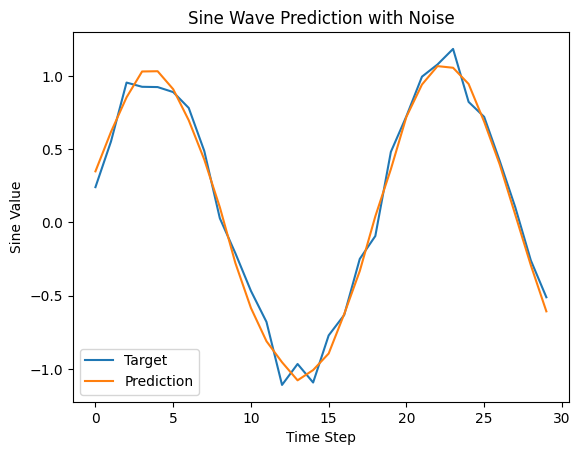

In [82]:
# テストと可視化
model.eval() # 評価モードに設定
with torch.no_grad():
    # テストデータの生成
    x_test, y_test = generate_sine_wave(sequence_length, batch_size=1, noise_level=noise_level)  # バッチサイズを1に
    predicted = model(x_test)

    # 結果の可視化
    #plt.plot(x_test[0, :, 0].cpu().numpy(), label='Input') # 入力データをプロット
    plt.plot(y_test[0, :, 0].cpu().numpy(), label='Target') # ターゲットデータをプロット
    plt.plot(predicted.squeeze().cpu().numpy(), label='Prediction') # 予測結果をプロット
    plt.legend()
    plt.title('Sine Wave Prediction with Noise') # タイトルを修正
    plt.xlabel('Time Step')
    plt.ylabel('Sine Value')
    plt.show()

**説明:**

*   テストフェーズでは、モデルの汎化性能を評価します。
*   `model.eval()`: モデルを評価モードに設定します。
*   `x_test, y_test = generate_sine_wave(sequence_length, batch_size=1, noise_level=noise_level)`: テストデータを生成します。
*   `predicted = model(x_test)`: モデルに入力データを渡して、予測結果を得ます。
*   可視化のために、Matplotlibを使用してグラフを作成します。
    *   入力データ、ターゲットデータ、予測データをそれぞれプロットします。
    *   予測データは、1ステップ右にずらして表示することで、予測の遅れや先行を視覚的に確認できます。
    *   グラフに凡例、タイトル、軸ラベルを追加します。

この詳細な説明で、各セルの役割とコードの動作をより深く理解できるはずです。